## Importing Libraries


torch – the main PyTorch library for building and training neural networks.

numpy – used for numerical operations and array manipulations.

torchvision.datasets and torchvision.transforms – for loading and preprocessing image datasets.

TensorDataset and DataLoader from torch.utils.data – to wrap data into tensors (multi-dimensional arrays) and efficiently load it in batches during training.

train_test_split from sklearn.model_selection – to split our dataset into training and testing subsets.

In [19]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

## Setting Hyperparameters and Configuration Values

#### RANDOM_SEED = 42
Ensures reproducibility — setting a fixed random seed makes sure that data splits, weight initialization, and other random operations give the same results each run.

#### BATCH_SIZE = 64
The number of samples processed before the model updates its parameters.
A typical starting point that balances speed and stability.

#### LR = 0.01
Controls how fast or slow the model learns during optimization.

#### INPUT_SIZE = 784  # 28 × 28
Each MNIST image (28×28 pixels) is flattened into a 784-dimensional vector, which serves as the input size for our model.

#### TEST_VALID_SIZE = 0.4
Specifies that 40% of the total data will be temporarily held out, to later be split evenly into validation (20%) and test (20%) sets.

In [7]:
RANDOM_SEED = 42 
BATCH_SIZE = 64
LR = 0.01 
INPUT_SIZE = 784 
TEST_VALID_SIZE = 0.4 
NUM_EPOCHS = 10

## Data Preparation (A1)

#### 1. Define Transformations and Load Full Data
    ToTensor() – converts each image to a PyTorch tensor and normalizes pixel values to the range [0, 1].

    Lambda(lambda x: x.flatten()) – reshapes each 28×28 grayscale image into a single vector of 784 values.

The MNIST training (60k) and test (10k) sets are both loaded, giving a total of 70,000 images.

#### 2. Combine and Split the Dataset

The full dataset is merged, normalized, and flattened, then, a two-step stratified split is performed using train_test_split:

    Step 1: 60% Training, 40% Temporary

    Step 2: Temporary (40%) → 20% Validation + 20% Test

stratify=y_combined ensures all subsets preserve the same class distribution across digits 0–9.

After splitting, all NumPy arrays are converted back to PyTorch tensors:

    X_train = torch.tensor(X_train_np).float()
    y_train = torch.tensor(y_train_np)

#### 3. Create DataLoaders (10-Class)

The train, validation, and test tensors are wrapped into TensorDatasets and passed into DataLoaders for efficient batching and shuffling:

    DATA_LOADERS_FULL = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    }

shuffle=True → randomizes training order for better generalization

In [ ]:
linear_model_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.flatten())
])

train_set_full = datasets.MNIST('./data', train=True, download=True, transform=linear_model_transforms)
test_set_full = datasets.MNIST('./data', train=False, download=True, transform=linear_model_transforms)

X_combined = torch.cat([train_set_full.data.float().div(255).flatten(start_dim=1),
                        test_set_full.data.float().div(255).flatten(start_dim=1)], dim=0).numpy()
y_combined = torch.cat([train_set_full.targets, test_set_full.targets], dim=0).numpy()

X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_combined, y_combined, 
    test_size=TEST_VALID_SIZE, 
    random_state=RANDOM_SEED, 
    stratify=y_combined 
)

X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, 
    test_size=0.5, 
    random_state=RANDOM_SEED, 
    stratify=y_temp_np 
)

X_train = torch.tensor(X_train_np).float()
X_val = torch.tensor(X_val_np).float()
X_test = torch.tensor(X_test_np).float()

y_train = torch.tensor(y_train_np)
y_val = torch.tensor(y_val_np)
y_test = torch.tensor(y_test_np)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

DATA_LOADERS_FULL = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

print(f"Part A1 Complete. Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")

Part A1 Complete. Train Size: 42000, Validation Size: 14000, Test Size: 14000


## Logistic Regression (A2)

### Core Components — Activation & Loss Functions

#### 1. Sigmoid Activation Function
    def sigmoid(z):
        Implementation of the Sigmoid activation function: 1 / (1 + e^(-z)).

The sigmoid maps any real-valued input z into a range between 0 and 1.

It’s commonly used in the output layer of binary classifiers to represent probabilities.

When z is large and positive → output ≈ 1

When z is large and negative → output ≈ 0

This makes it ideal for predicting probabilities such as “this image is a 5 or not.”

#### 2. Binary Cross-Entropy (BCE) Loss
    def binary_cross_entropy_loss(y_hat, y):
        Implementation of the Binary Cross-Entropy loss function.
        

Measures the difference between predicted probabilities (y_hat) and true binary labels (y).
Used to penalize incorrect predictions more strongly the more confident they are.

#### Notes:

 - Epsilon = 1e-7 prevents taking log(0), which would cause numerical instability.

 - Both y and y_hat are reshaped to match dimensions for batch-wise computation.

In [ ]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def binary_cross_entropy_loss(y_hat, y):
    y = y.view(-1, 1)
    epsilon = 1e-7
    loss = - torch.mean(y * torch.log(y_hat + epsilon) + (1 - y) * torch.log(1 - y_hat + epsilon))
    return loss

### Data Preparation — Filtering Digits 0 and 1

### Function Overview
    def create_binary_loaders(X, y, batch_size):
        Filters global tensors for classes 0 and 1, creates DataLoaders.

1. Selects samples where the label (y) is either 0 or 1.
2. Converts the filtered data into tensors.
3. Wraps them inside a PyTorch DataLoader for efficient iteration

### Step-by-Step Breakdown

#### Filter Digits 0 and 1

    indices = (y == 0) | (y == 1)
    X_binary = X[indices].float()
    y_binary = y[indices].float()


Creates a boolean mask selecting only images of digits 0 and 1.

Converts both input and labels to float type (required for Binary Cross-Entropy loss).

#### Determine Shuffle Behavior

    shuffle_status = True if X.shape[0] == X_train.shape[0] else False


Enables shuffling only for the training set (to randomize sample order each epoch).

Keeps validation and test sets unshuffled for consistency.

#### Return DataLoader

    return DataLoader(TensorDataset(X_binary, y_binary),
                    batch_size=batch_size,
                    shuffle=shuffle_status)


Wraps the filtered tensors into a TensorDataset and returns a DataLoader.

batch_size controls how many samples are processed per step.

In [10]:
def create_binary_loaders(X, y, batch_size):
    indices = (y == 0) | (y == 1)
    X_binary = X[indices].float()
    y_binary = y[indices].float() 
    
    shuffle_status = True if X.shape[0] == X_train.shape[0] else False
    
    return DataLoader(TensorDataset(X_binary, y_binary), batch_size=batch_size, shuffle=shuffle_status)

### Training Function (Manual Gradient Descent)

#### Function Overview
def train_logistic_regression(loader, W, b, learning_rate):


Inputs:

    loader → DataLoader containing batches of input–label pairs

    W, b → model parameters (weights and bias)

    learning_rate → step size for parameter updates

Outputs:

    Average loss over the epoch

    Average accuracy across all samples

#### Step-by-Step Breakdown
#### 1.  Forward Pass
    Z = torch.matmul(X_batch, W) + b  # Linear output
    A = sigmoid(Z)                    # Activation (probability)

Computes the model’s predictions:

where A represents predicted probabilities (values between 0 and 1).

#### 2. Compute Loss
    loss = binary_cross_entropy_loss(A, y_batch)    

Uses the Binary Cross-Entropy (BCE) loss to measure how far predictions are from true labels.

Total loss is accumulated for averaging later:
A=σ(XW+b) *insert sigmoid func*

    total_loss += loss.item() * X_batch.size(0)

#### 3. Backward Pass
    if W.grad is not None: W.grad.zero_()
    if b.grad is not None: b.grad.zero_()
    loss.backward()


Clears previous gradients.

Uses autograd (loss.backward()) to compute new gradients
→ dL/dW and dL/db.

#### 4. Manual Parameter Update
    with torch.no_grad():
        W.data -= learning_rate * W.grad
        b.data -= learning_rate * b.grad

Performs gradient descent manually:
*insert gd func*

(This is equivalent to what an optimizer like torch.optim.SGD would do.)

#### 5. Compute Metrics
    predictions = (A >= 0.5).float().view(-1)
    correct_predictions += (predictions == y_batch).sum().item()

Thresholds predicted probabilities at 0.5 → binary class labels (0 or 1).

Tracks number of correct predictions for accuracy computation.

In [ ]:
def train_logistic_regression(loader, W, b, learning_rate):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for X_batch, y_batch in loader:
        Z = torch.matmul(X_batch, W) + b  
        A = sigmoid(Z)                   
        
        loss = binary_cross_entropy_loss(A, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        if W.grad is not None: W.grad.zero_()
        if b.grad is not None: b.grad.zero_()
        loss.backward()

        with torch.no_grad():
            W.data -= learning_rate * W.grad
            b.data -= learning_rate * b.grad
            
        predictions = (A >= 0.5).float().view(-1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy

### Evaluation Function — Model Testing / Validation

### Decorator:
    @torch.no_grad() 
Disables gradient tracking — this saves memory and speeds up evaluation since we’re not updating parameters.

### Step-by-Step Explanation
#### 1. Initialize Metrics
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []


Keeps running totals for:
1. cumulative loss
2. correct predictions
3. number of processed samples
4. lists of predictions and targets (for later analysis)

#### 2. Forward Pass (Inference)
    Z = torch.matmul(X_batch, W) + b
    A = sigmoid(Z)

Computes the model’s predicted probability for each input:
A=σ(XW+b)

#### 3. Compute Loss
    loss = binary_cross_entropy_loss(A, y_batch)
    total_loss += loss.item() * X_batch.size(0)


Uses the same Binary Cross-Entropy loss used during training, but here it’s only for evaluation — parameters are not updated.

#### 4. Compute Accuracy
    predictions = (A >= 0.5).float().view(-1)
    correct_predictions += (predictions == y_batch).sum().item()
    total_samples += X_batch.size(0)

Converts probabilities to binary predictions (0 or 1)
Counts how many predictions match the true labels

#### 5. Collect Predictions and Labels
    all_preds.extend(predictions.tolist())
    all_targets.extend(y_batch.tolist())


Stores every prediction and corresponding target for detailed post-analysis (like plotting curves or confusion matrices).

#### 6. Compute Averages
    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples

Calculates the mean loss and accuracy across the entire dataset.

In [ ]:
@torch.no_grad()
def evaluate_model(loader, W, b):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    for X_batch, y_batch in loader:
        Z = torch.matmul(X_batch, W) + b
        A = sigmoid(Z)
        loss = binary_cross_entropy_loss(A, y_batch)
        total_loss += loss.item() * X_batch.size(0)

        predictions = (A >= 0.5).float().view(-1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += X_batch.size(0)
        
        all_preds.extend(predictions.tolist())
        all_targets.extend(y_batch.tolist())

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy, all_targets, all_preds

### Binary Logistic Regression (Digits 0 vs 1)

#### 1. Create Binary DataLoaders
    train_loader_binary = create_binary_loaders(X_train, y_train, BATCH_SIZE)
    val_loader_binary   = create_binary_loaders(X_val, y_val, BATCH_SIZE)
    test_loader_binary  = create_binary_loaders(X_test, y_test, BATCH_SIZE)

Filters the dataset to keep only samples where label == 0 or label == 1.

Creates PyTorch DataLoaders for mini-batch training and evaluation.

The training loader shuffles its data each epoch, while validation/test loaders do not.

#### 2. Initialize Parameters
    W = torch.randn(INPUT_SIZE, 1) * 0.01
    b = torch.zeros(1)
    W.requires_grad_(True)
    b.requires_grad_(True)

W → weight vector (shape [784 × 1]) initialized with small random values.

b → bias term initialized to 0.

Setting requires_grad_(True) tells PyTorch to track gradients so we can update these parameters during training.

#### 3. Prepare for Training Loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

Lists to record loss and accuracy at the end of each epoch, for both training and validation sets.

In [ ]:
train_loader_binary = create_binary_loaders(X_train, y_train, BATCH_SIZE)
val_loader_binary = create_binary_loaders(X_val, y_val, BATCH_SIZE)
test_loader_binary = create_binary_loaders(X_test, y_test, BATCH_SIZE)

print(f"Binary Training Samples: {len(train_loader_binary.dataset)}")

W = torch.randn(INPUT_SIZE, 1) * 0.01
b = torch.zeros(1)
W.requires_grad_(True)
b.requires_grad_(True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

Binary Training Samples: 8868


### Training and Evaluating the Logistic Regression Model

#### 1. Epoch Loop
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_logistic_regression(train_loader_binary, W, b, LR)
        val_loss, val_acc, _, _ = evaluate_model(val_loader_binary, W, b)


Each epoch runs one full pass over the training set and validation set.

The training function:

 - Performs forward propagation, computes loss, and manually updates parameters (W, b) using gradient descent.

The validation step:

 - Runs the model in evaluation mode (no gradient computation) to check for overfitting or underfitting.

#### 2.Record Metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

Stores loss and accuracy for later visualization.
These values help you plot learning curves and analyze model performance across epochs.

#### 3. Final Test Evaluation
    test_loss, test_acc, true_labels, predictions = evaluate_model(test_loader_binary, W, b)
    print(f"Test Accuracy: {test_acc:.4f}")


After training, we evaluate the model on the unseen test set to get an unbiased estimate of performance.
The test_acc gives the final accuracy on digits 0 vs 1.

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_logistic_regression(train_loader_binary, W, b, LR)
    
    val_loss, val_acc, _, _ = evaluate_model(val_loader_binary, W, b)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

test_loss, test_acc, true_labels, predictions = evaluate_model(test_loader_binary, W, b)

print(f"\n--- A2 Final Test Evaluation ---")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 0.2152, Train Acc: 0.9878 | Val Loss: 0.0913, Val Acc: 0.9973
Epoch 2/10 | Train Loss: 0.0698, Train Acc: 0.9966 | Val Loss: 0.0531, Val Acc: 0.9980
Epoch 3/10 | Train Loss: 0.0466, Train Acc: 0.9968 | Val Loss: 0.0392, Val Acc: 0.9980
Epoch 4/10 | Train Loss: 0.0363, Train Acc: 0.9970 | Val Loss: 0.0318, Val Acc: 0.9980
Epoch 5/10 | Train Loss: 0.0304, Train Acc: 0.9970 | Val Loss: 0.0272, Val Acc: 0.9980
Epoch 6/10 | Train Loss: 0.0265, Train Acc: 0.9973 | Val Loss: 0.0240, Val Acc: 0.9980
Epoch 7/10 | Train Loss: 0.0237, Train Acc: 0.9975 | Val Loss: 0.0217, Val Acc: 0.9980
Epoch 8/10 | Train Loss: 0.0216, Train Acc: 0.9975 | Val Loss: 0.0199, Val Acc: 0.9980
Epoch 9/10 | Train Loss: 0.0199, Train Acc: 0.9979 | Val Loss: 0.0185, Val Acc: 0.9980
Epoch 10/10 | Train Loss: 0.0186, Train Acc: 0.9979 | Val Loss: 0.0173, Val Acc: 0.9980

--- A2 Final Test Evaluation ---
Test Accuracy: 0.9976


### Loss curve plot


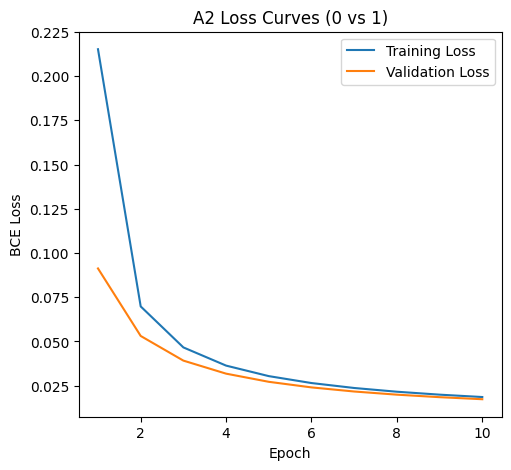

In [16]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('A2 Loss Curves (0 vs 1)')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()

### Accuracy curve plot


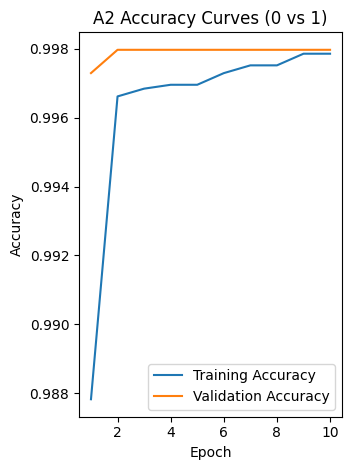

In [17]:
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('A2 Accuracy Curves (0 vs 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Confusion matrix


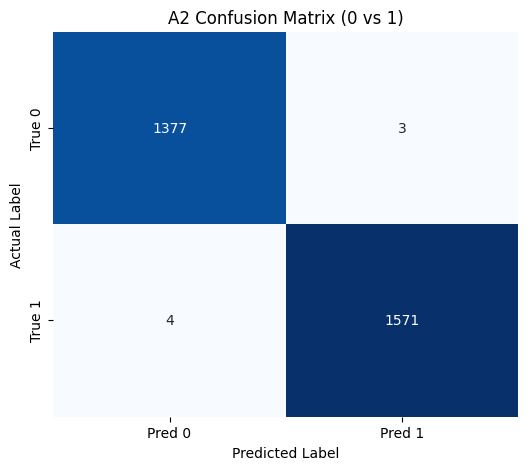

In [18]:
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('A2 Confusion Matrix (0 vs 1)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Softmax Regression (A3)

#### 1. Retrieve DataLoaders
    train_loader_full = DATA_LOADERS_FULL['train']
    val_loader_full   = DATA_LOADERS_FULL['val']
    test_loader_full  = DATA_LOADERS_FULL['test']

We use the full dataset (10 classes) prepared earlier in Part A1.
These DataLoaders provide batches of (images, labels) for training, validation, and testing.

#### 2. Define Hyperparameters
    LR_SOFTMAX = 0.01 
    NUM_EPOCHS_SOFTMAX = 15

 - Learning rate (LR_SOFTMAX): Controls the update step size for each gradient descent iteration.

 - Epochs (NUM_EPOCHS_SOFTMAX): Softmax models often need more training epochs than binary ones to converge well.

### Core Components — Softmax Activation & Cross - Entropy Loss Functions

#### 1. Softmax Activation
	def softmax(z):
		...

The Softmax function converts raw model outputs (z) into a probability distribution over all classes: *insert softmax function* 


Subtracting the maximum value in z (z_max) is a numerical stability trick to prevent overflow when exponentiating large numbers.

#### 2. Multi-Class Cross-Entropy Loss
	def multi_class_cross_entropy_loss(y_hat, y):
		...


The Cross-Entropy loss measures how well the predicted probability distribution (y_hat) matches the true labels (y).

Steps:

1. Convert labels y into one-hot vectors (e.g., class 3 → [0, 0, 0, 1, 0, …]).

2. Compute


*insert cross entropy loss function*

for each sample.

3. Take the mean across the batch to get the final loss.

This loss encourages the model to assign high probability to the correct class and penalize confident wrong predictions.

In [20]:
train_loader_full = DATA_LOADERS_FULL['train']
val_loader_full = DATA_LOADERS_FULL['val']
test_loader_full = DATA_LOADERS_FULL['test']

LR_SOFTMAX = 0.01 
NUM_EPOCHS_SOFTMAX = 15

def softmax(z):
    z_max = torch.max(z, dim=1, keepdim=True).values
    e_z = torch.exp(z - z_max)
    sum_e_z = torch.sum(e_z, dim=1, keepdim=True)
    return e_z / sum_e_z

def multi_class_cross_entropy_loss(y_hat, y):
    num_classes = y_hat.size(1)
    y_one_hot = F.one_hot(y.long(), num_classes=num_classes).float()
    epsilon = 1e-7
    loss = - torch.sum(y_one_hot * torch.log(y_hat + epsilon), dim=1)
    return torch.mean(loss)

### Training Function (Manual Gradient Descent)

#### 1. Forward Pass
    Z = torch.matmul(X_batch, W) + b  # (N, 10)
    A = softmax(Z)                    # (N, 10)


Z represents the raw scores (logits) for each of the 10 classes.

Applying Softmax converts these scores into a probability distribution across classes for each input sample.

#### 2. Compute Loss
    loss = multi_class_cross_entropy_loss(A, y_batch)

Uses the multi-class cross-entropy loss to measure how close the predicted probabilities are to the true labels.

The loss encourages higher probabilities for the correct class.

#### 3. Backward Pass (Gradient Computation)
    if W.grad is not None: W.grad.zero_()
    if b.grad is not None: b.grad.zero_()
    loss.backward()

Clears existing gradients to prevent accumulation.

Calls .backward() to compute gradients dL/dW and dL/db using PyTorch’s autograd engine.

#### 4. Manual Gradient Descent Update
    with torch.no_grad():
        W.data -= learning_rate * W.grad
        b.data -= learning_rate * b.grad

Updates the model parameters manually (without using an optimizer).

The update rule:
W:=W−η∂W/∂L​,b:=b−η∂b/∂L​


where 
𝜂
η is the learning rate.

#### 5. Accuracy Computation
    predictions = torch.argmax(A, dim=1)
    correct_predictions += (predictions == y_batch).sum().item()

For each sample, the class with the highest probability is chosen as the prediction.

Accuracy is calculated as the proportion of correctly classified samples.

In [21]:
def train_softmax_regression(loader, W, b, learning_rate):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for X_batch, y_batch in loader:
        Z = torch.matmul(X_batch, W) + b  
        A = softmax(Z)                   
        
        loss = multi_class_cross_entropy_loss(A, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        if W.grad is not None: W.grad.zero_()
        if b.grad is not None: b.grad.zero_()
        loss.backward()

        with torch.no_grad():
            W.data -= learning_rate * W.grad
            b.data -= learning_rate * b.grad
            
        predictions = torch.argmax(A, dim=1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy

### Evaluation Function for Softmax Regression

#### No Gradient Tracking
@torch.no_grad()


This decorator disables gradient computation, making evaluation faster and memory-efficient since no backpropagation is needed during inference.

#### 1. Forward Pass
    Z = torch.matmul(X_batch, W) + b
    A = softmax(Z)

Computes the logits Z and applies Softmax to obtain class probabilities for each input sample.

#### 2. Compute Loss
    loss = multi_class_cross_entropy_loss(A, y_batch)

Uses the multi-class cross-entropy loss to quantify how well the predicted probabilities match the true class labels.

The loss is averaged over all samples in the batch and accumulated.

#### 3. Compute Accuracy
    predictions = torch.argmax(A, dim=1)
    correct_predictions += (predictions == y_batch).sum().item()


Takes the argmax (index of the largest probability) as the predicted class.

Compares it with true labels to count correct predictions.

#### 4. Track Results
    all_preds.extend(predictions.tolist())
    all_targets.extend(y_batch.tolist())


Collects all predictions and ground truths for potential later use (e.g., confusion matrix or classification report).

In [22]:
@torch.no_grad()
def evaluate_softmax_model(loader, W, b):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    for X_batch, y_batch in loader:
        Z = torch.matmul(X_batch, W) + b
        A = softmax(Z)
        loss = multi_class_cross_entropy_loss(A, y_batch)
        total_loss += loss.item() * X_batch.size(0)

        predictions = torch.argmax(A, dim=1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += X_batch.size(0)
        
        all_preds.extend(predictions.tolist())
        all_targets.extend(y_batch.tolist())

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy, all_targets, all_preds

### Initializing Parameters for the Softmax Model

#### 1. Define Model Parameters
    NUM_CLASSES = 10
    W_softmax = torch.randn(INPUT_SIZE, NUM_CLASSES) * 0.01
    b_softmax = torch.zeros(NUM_CLASSES)
    W_softmax.requires_grad_(True)
    b_softmax.requires_grad_(True)


W_softmax: Weight matrix of shape (784, 10) — connects each input pixel to each of the 10 output classes.

Initialized with small random values (scaled by 0.01) to break symmetry between neurons.

b_softmax: Bias vector of shape (10,), initialized to zeros.

Both parameters have requires_grad=True to enable automatic differentiation for gradient-based updates during training.

#### 2. Prepare Metric Storage
    train_losses_sm, val_losses_sm = [], []
    train_accuracies_sm, val_accuracies_sm = [], []

These lists will track the model’s loss and accuracy on both the training and validation datasets across epochs.
They’re later used to plot learning curves and assess how well the model converges.

In [23]:
NUM_CLASSES = 10
W_softmax = torch.randn(INPUT_SIZE, NUM_CLASSES) * 0.01
b_softmax = torch.zeros(NUM_CLASSES)
W_softmax.requires_grad_(True)
b_softmax.requires_grad_(True)

train_losses_sm, val_losses_sm = [], []
train_accuracies_sm, val_accuracies_sm = [], []

### Training the Softmax Regression Model

#### 1. Training Phase:
Each epoch runs one full pass through the training dataset (train_loader_full).
The train_softmax_regression() function:

 - Performs a forward pass.

 - Computes the multi-class cross-entropy loss.

 - Backpropagates the gradients.

 - Manually updates W_softmax and b_softmax.

#### 2. Validation Phase:
After each epoch, we use evaluate_softmax_model() on the validation set to:

 - Measure the model’s generalization ability.

 - Track potential overfitting by comparing training and validation metrics.

#### 3. Progress Logging:
The print statement displays per-epoch metrics, making it easy to monitor convergence.

In [24]:
for epoch in range(NUM_EPOCHS_SOFTMAX):
    train_loss, train_acc = train_softmax_regression(train_loader_full, W_softmax, b_softmax, LR_SOFTMAX)
    
    val_loss, val_acc, _, _ = evaluate_softmax_model(val_loader_full, W_softmax, b_softmax)
    
    train_losses_sm.append(train_loss)
    val_losses_sm.append(val_loss)
    train_accuracies_sm.append(train_acc)
    val_accuracies_sm.append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS_SOFTMAX} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/15 | Train Loss: 1.1046, Train Acc: 0.7971 | Val Loss: 0.7151, Val Acc: 0.8497
Epoch 2/15 | Train Loss: 0.6172, Train Acc: 0.8612 | Val Loss: 0.5568, Val Acc: 0.8674
Epoch 3/15 | Train Loss: 0.5169, Train Acc: 0.8732 | Val Loss: 0.4931, Val Acc: 0.8761
Epoch 4/15 | Train Loss: 0.4685, Train Acc: 0.8810 | Val Loss: 0.4574, Val Acc: 0.8821
Epoch 5/15 | Train Loss: 0.4386, Train Acc: 0.8866 | Val Loss: 0.4338, Val Acc: 0.8856
Epoch 6/15 | Train Loss: 0.4180, Train Acc: 0.8899 | Val Loss: 0.4166, Val Acc: 0.8890
Epoch 7/15 | Train Loss: 0.4025, Train Acc: 0.8929 | Val Loss: 0.4037, Val Acc: 0.8916
Epoch 8/15 | Train Loss: 0.3904, Train Acc: 0.8955 | Val Loss: 0.3930, Val Acc: 0.8949
Epoch 9/15 | Train Loss: 0.3806, Train Acc: 0.8975 | Val Loss: 0.3848, Val Acc: 0.8956
Epoch 10/15 | Train Loss: 0.3724, Train Acc: 0.8996 | Val Loss: 0.3774, Val Acc: 0.8975
Epoch 11/15 | Train Loss: 0.3654, Train Acc: 0.9010 | Val Loss: 0.3719, Val Acc: 0.8990
Epoch 12/15 | Train Loss: 0.3593, Train A

### Final Test Evaluation


In [25]:
test_loss, test_acc, true_labels, predictions = evaluate_softmax_model(test_loader_full, W_softmax, b_softmax)

print(f"\n--- A3 Final Test Evaluation ---")
print(f"Test Accuracy: {test_acc:.4f}")


--- A3 Final Test Evaluation ---
Test Accuracy: 0.9019


### Loss Curve Plot


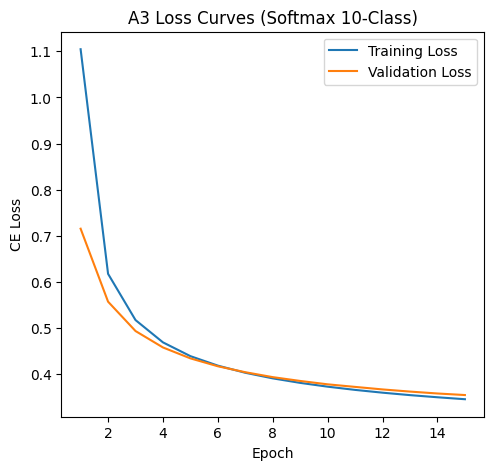

In [26]:
epochs_sm = range(1, NUM_EPOCHS_SOFTMAX + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_sm, train_losses_sm, label='Training Loss')
plt.plot(epochs_sm, val_losses_sm, label='Validation Loss')
plt.title('A3 Loss Curves (Softmax 10-Class)')
plt.xlabel('Epoch')
plt.ylabel('CE Loss')
plt.legend()

### Accuracy Curve Plot


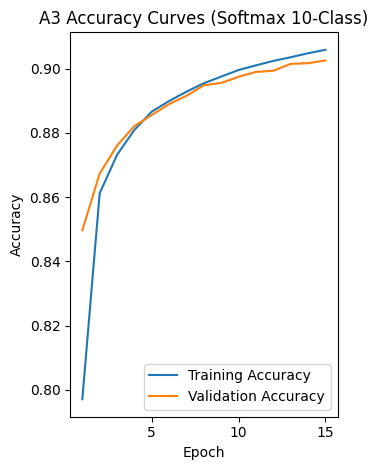

In [27]:
plt.subplot(1, 2, 2)
plt.plot(epochs_sm, train_accuracies_sm, label='Training Accuracy')
plt.plot(epochs_sm, val_accuracies_sm, label='Validation Accuracy')
plt.title('A3 Accuracy Curves (Softmax 10-Class)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Confusion Matrix

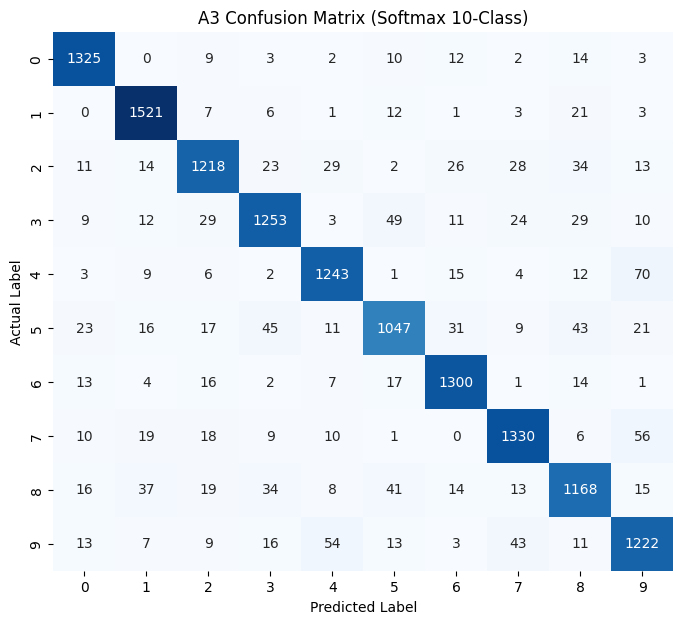

In [28]:
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=range(NUM_CLASSES), columns=range(NUM_CLASSES))

plt.figure(figsize=(8, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('A3 Confusion Matrix (Softmax 10-Class)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()